Loading and adjusting data for inflation...
Target CPI (2025-01): 273.003
Successfully adjusted 641 observations
Missing CPI data for 0 observations

Inflation adjustment summary by year:
           avg_inflation_factor  avg_original_val  avg_adjusted_val  count
from_year                                                                 
2016                      1.158      1.713403e+07      1.988402e+07     51
2017                      1.153      1.065341e+07      1.228088e+07     64
2018                      1.149      9.044589e+06      1.039076e+07     75
2019                      1.132      6.302117e+06      7.123483e+06    105
2020                      1.114      1.239147e+07      1.380056e+07     64
2021                      1.088      2.566433e+07      2.789525e+07     86
2022                      1.075      2.676765e+07      2.874089e+07     51
2023                      1.061      1.266294e+07      1.344995e+07     31
2024                      1.040      9.606646e+06      9.92129

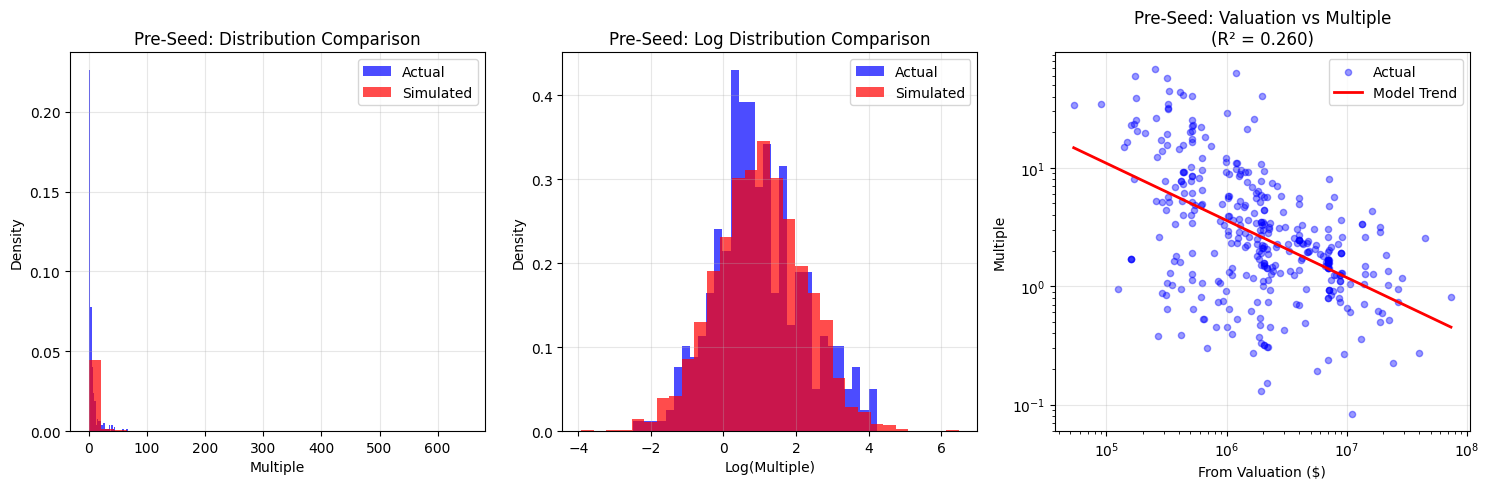


SEED:
  Mean difference: -4.5%
  Std difference: -17.0%
  Median difference: 3.0%
  KS test p-value: 0.1182


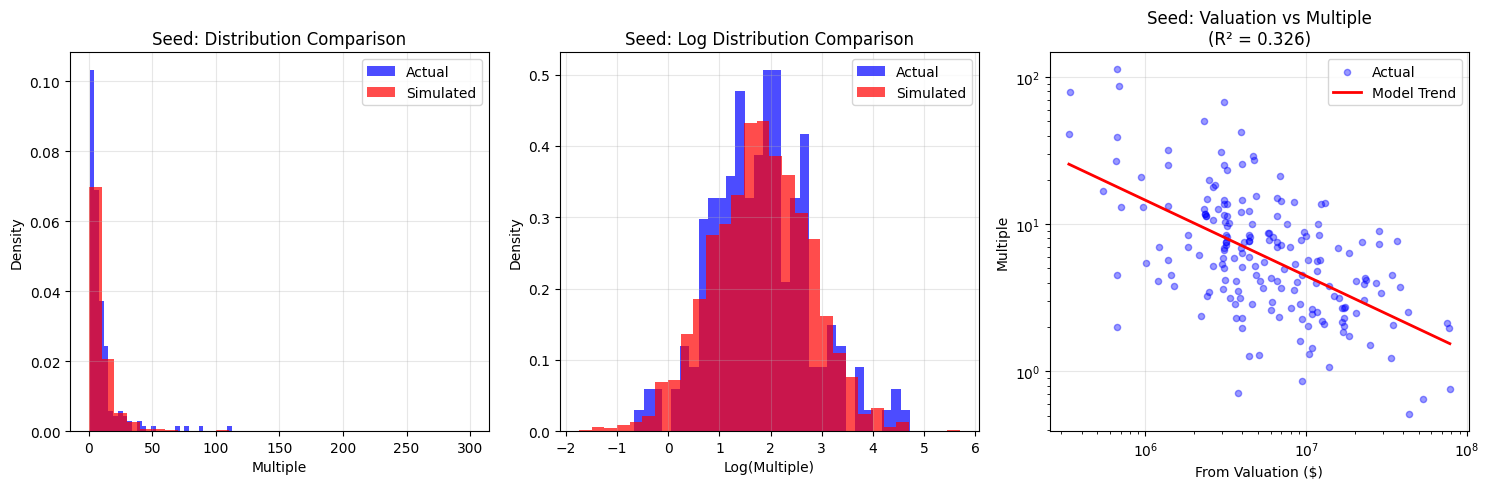


SERIES A:
  Mean difference: 1.2%
  Std difference: 8.5%
  Median difference: -13.2%
  KS test p-value: 0.5625


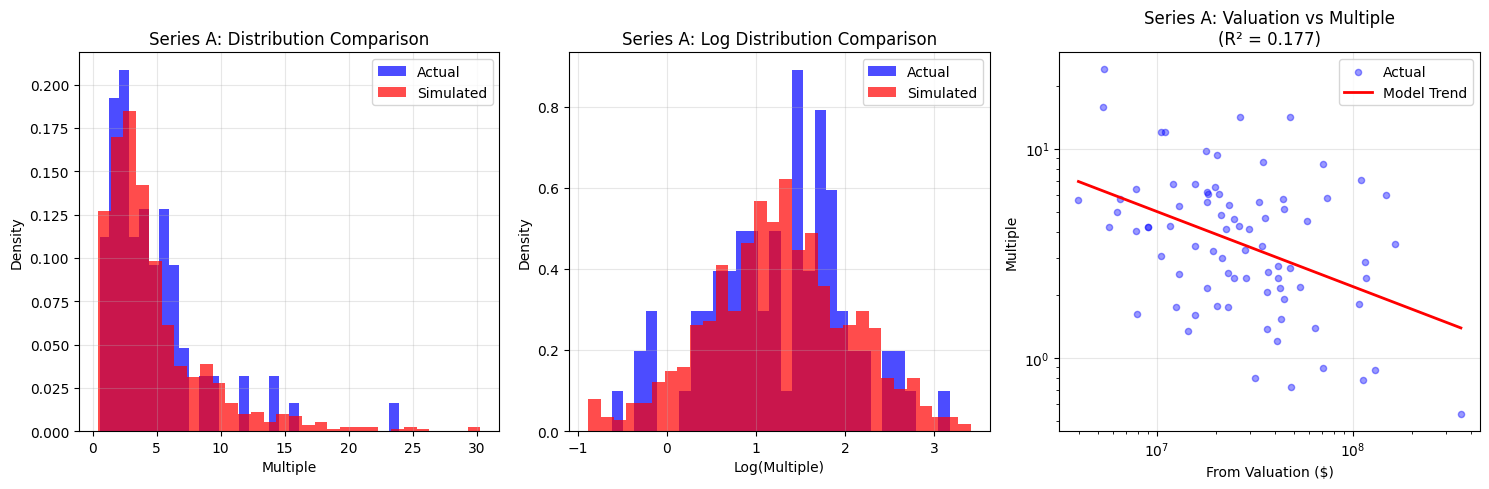


SERIES B:
  Mean difference: 1.3%
  Std difference: 16.5%
  Median difference: 7.2%
  KS test p-value: 0.3356


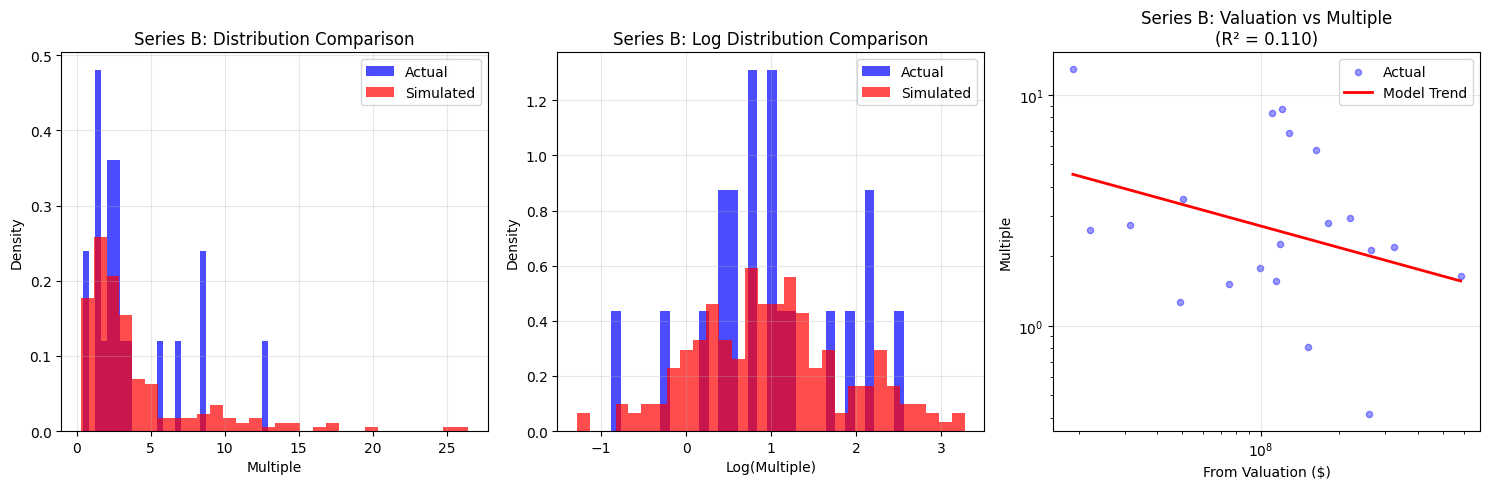


UPDATED MODEL PARAMETERS (with inflation adjustment)
Pre-Seed: alpha=7.9486, beta=0.4827, residual_std=1.0611
Seed: alpha=9.7825, beta=0.5143, residual_std=0.7827
Series A: alpha=7.3913, beta=0.3586, residual_std=0.6927
Series B: alpha=6.7182, beta=0.3107, residual_std=0.7697

Model ready for Monte Carlo simulation with inflation-adjusted valuations!
Use model.simulate_multiples(stage, valuations, n_simulations) for bulk simulation


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from typing import Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

def load_and_adjust_data(company_file: str = 'company_transitions.csv', 
                        cpi_file: str = 'CPI.csv', 
                        target_date: str = '2025-01-01') -> pd.DataFrame:
    """
    Load company transition data and adjust historical valuations for inflation.
    
    Parameters:
    company_file: Path to company transitions CSV
    cpi_file: Path to CPI data CSV
    target_date: Target date for inflation adjustment (default: January 2025)
    
    Returns:
    DataFrame with inflation-adjusted valuations
    """
    # Load CPI data
    cpi_data = pd.read_csv(cpi_file)
    
    # Create CPI lookup table
    cpi_lookup = {}
    for _, row in cpi_data.iterrows():
        try:
            date = pd.to_datetime(row['year_month'])
            key = f"{date.year}-{date.month:02d}"
            cpi_lookup[key] = row['cpi']
        except:
            continue
    
    # Get target CPI (January 2025)
    target_year_month = pd.to_datetime(target_date)
    target_key = f"{target_year_month.year}-{target_year_month.month:02d}"
    target_cpi = cpi_lookup.get(target_key)
    
    if not target_cpi:
        # If exact target not found, use the closest available
        available_dates = sorted(cpi_lookup.keys())
        target_cpi = cpi_lookup[available_dates[-1]]  # Use most recent
        print(f"Warning: Using CPI from {available_dates[-1]} instead of {target_key}")
    
    print(f"Target CPI ({target_key}): {target_cpi}")
    
    # Load company data
    company_data = pd.read_csv(company_file)
    
    # Filter and adjust data
    adjusted_rows = []
    missing_cpi_count = 0
    
    for _, row in company_data.iterrows():
        if (pd.isna(row['from_date']) or pd.isna(row['from_valuation']) or 
            pd.isna(row['multiple']) or row['from_valuation'] <= 0 or row['multiple'] <= 0):
            continue
            
        try:
            date = pd.to_datetime(row['from_date'])
            historical_key = f"{date.year}-{date.month:02d}"
            historical_cpi = cpi_lookup.get(historical_key)
            
            if not historical_cpi:
                missing_cpi_count += 1
                continue
            
            # Calculate inflation adjustment
            inflation_factor = target_cpi / historical_cpi
            adjusted_valuation = row['from_valuation'] * inflation_factor
            
            adjusted_row = row.copy()
            adjusted_row['original_from_valuation'] = row['from_valuation']
            adjusted_row['inflation_factor'] = inflation_factor
            adjusted_row['from_valuation'] = adjusted_valuation  # Replace with adjusted value
            adjusted_row['from_year'] = date.year
            
            adjusted_rows.append(adjusted_row)
            
        except Exception as e:
            missing_cpi_count += 1
            continue
    
    result_df = pd.DataFrame(adjusted_rows)
    
    print(f"Successfully adjusted {len(result_df)} observations")
    print(f"Missing CPI data for {missing_cpi_count} observations")
    
    # Show inflation impact summary
    if len(result_df) > 0:
        impact_summary = result_df.groupby('from_year').agg({
            'inflation_factor': 'mean',
            'original_from_valuation': 'mean',
            'from_valuation': 'mean',
            'company': 'count'
        }).round(3)
        impact_summary.columns = ['avg_inflation_factor', 'avg_original_val', 'avg_adjusted_val', 'count']
        
        print("\nInflation adjustment summary by year:")
        print(impact_summary.tail(10))  # Show last 10 years
        
        overall_increase = (result_df['from_valuation'].mean() / result_df['original_from_valuation'].mean() - 1) * 100
        print(f"\nOverall valuation increase due to inflation: {overall_increase:.1f}%")
    
    return result_df

class ConditionalMultipleModel:
    """
    Model for predicting valuation multiples conditional on stage and initial valuation.
    Uses log-linear relationship: log(multiple) = alpha - beta * log(from_valuation) + noise
    """
    
    def __init__(self):
        self.models = {}  # Store model parameters for each stage
        self.fitted = False
        
    def fit(self, data: pd.DataFrame) -> None:
        """
        Fit the conditional model for each stage.
        
        Parameters:
        data: DataFrame with columns ['from_stage', 'from_valuation', 'multiple']
              If inflation adjustment was performed, should also have 'original_from_valuation' and 'inflation_factor'
        """
        self.models = {}
        
        # Group by stage and fit model for each
        for stage in data['from_stage'].unique():
            stage_data = data[data['from_stage'] == stage].copy()
            
            # Filter valid data
            valid_mask = (stage_data['from_valuation'] > 0) & (stage_data['multiple'] > 0)
            stage_data = stage_data[valid_mask]
            
            if len(stage_data) < 5:  # Need minimum observations
                print(f"Warning: Too few observations for {stage} ({len(stage_data)})")
                continue
                
            # Prepare variables (using inflation-adjusted valuations)
            X = np.log(stage_data['from_valuation'].values).reshape(-1, 1)
            y = np.log(stage_data['multiple'].values)
            
            # Fit linear regression
            reg = LinearRegression().fit(X, y)
            
            # Calculate residuals and statistics
            y_pred = reg.predict(X)
            residuals = y - y_pred
            residual_std = np.std(residuals)
            r2 = r2_score(y, y_pred)
            
            # Store model parameters
            self.models[stage] = {
                'alpha': reg.intercept_,
                'beta': -reg.coef_[0],  # Negative because we expect inverse relationship
                'residual_std': residual_std,
                'r2': r2,
                'n_obs': len(stage_data),
                'val_range': (stage_data['from_valuation'].min(), stage_data['from_valuation'].max()),
                'mult_range': (stage_data['multiple'].min(), stage_data['multiple'].max())
            }
            
        self.fitted = True
        self.data = data  # Store for later use
        print("Model fitted successfully!")
        self._print_summary()
    
    def _print_summary(self) -> None:
        """Print model summary statistics."""
        print("\n" + "="*60)
        print("CONDITIONAL MULTIPLE MODEL SUMMARY")
        print("="*60)
        
        # Show inflation adjustment impact in summary
        inflation_impact = ""
        if 'inflation_factor' in self.data.columns:
            avg_inflation = self.data['inflation_factor'].mean()
            inflation_impact = f" (Inflation-adjusted by {avg_inflation:.2f}x to Jan 2025)"
        
        for stage, params in self.models.items():
            stage_data = self.data[self.data['from_stage'] == stage]
            avg_original = stage_data.get('original_from_valuation', stage_data['from_valuation']).mean()
            
            print(f"\n{stage.upper()} STAGE:")
            print(f"  Observations: {params['n_obs']}")
            print(f"  Model: log(multiple) = {params['alpha']:.3f} - {params['beta']:.3f} * log(valuation)")
            print(f"  R²: {params['r2']:.3f}")
            print(f"  Residual Std: {params['residual_std']:.3f}")
            print(f"  Valuation Range: ${params['val_range'][0]:,.0f} - ${params['val_range'][1]:,.0f}{inflation_impact}")
            print(f"  Multiple Range: {params['mult_range'][0]:.2f} - {params['mult_range'][1]:.2f}")
            
            if 'original_from_valuation' in stage_data.columns:
                print(f"  Avg Original Valuation: ${avg_original:,.0f}")
                print(f"  Avg Adjusted Valuation: ${stage_data['from_valuation'].mean():,.0f}")
        
        # Store data for later use
        self.data = data
    
    def predict_multiple(self, stage: str, from_valuation: float, random_seed: int = None) -> float:
        """
        Predict a single multiple for given stage and valuation.
        
        Parameters:
        stage: Stage name (e.g., 'Seed', 'Series A')
        from_valuation: Current valuation
        random_seed: For reproducible random sampling
        
        Returns:
        Predicted multiple
        """
        if not self.fitted:
            raise ValueError("Model must be fitted before prediction")
        
        if stage not in self.models:
            raise ValueError(f"Stage '{stage}' not found in fitted models")
        
        if random_seed is not None:
            np.random.seed(random_seed)
        
        params = self.models[stage]
        
        # Calculate expected log(multiple)
        expected_log_multiple = params['alpha'] - params['beta'] * np.log(from_valuation)
        
        # Add random noise
        noise = np.random.normal(0, params['residual_std'])
        actual_log_multiple = expected_log_multiple + noise
        
        # Transform back to multiple
        return np.exp(actual_log_multiple)
    
    def simulate_multiples(self, stage: str, from_valuations: np.ndarray, 
                          n_simulations: int = 1, random_seed: int = None) -> np.ndarray:
        """
        Simulate multiples for given stage and valuations.
        
        Parameters:
        stage: Stage name
        from_valuations: Array of starting valuations
        n_simulations: Number of simulations per valuation
        random_seed: For reproducible results
        
        Returns:
        Array of shape (len(from_valuations), n_simulations) with predicted multiples
        """
        if not self.fitted:
            raise ValueError("Model must be fitted before simulation")
        
        if stage not in self.models:
            raise ValueError(f"Stage '{stage}' not found in fitted models")
        
        if random_seed is not None:
            np.random.seed(random_seed)
        
        params = self.models[stage]
        
        # Calculate expected log(multiples) for all valuations
        expected_log_multiples = params['alpha'] - params['beta'] * np.log(from_valuations)
        
        # Generate random noise
        noise = np.random.normal(0, params['residual_std'], 
                               size=(len(from_valuations), n_simulations))
        
        # Add noise and transform back
        log_multiples = expected_log_multiples.reshape(-1, 1) + noise
        multiples = np.exp(log_multiples)
        
        return multiples
    
    def validate_model(self, data: pd.DataFrame, stage: str, n_simulations: int = 1000) -> Dict:
        """
        Validate model by comparing simulated vs actual distributions.
        
        Parameters:
        data: Original data
        stage: Stage to validate
        n_simulations: Number of Monte Carlo simulations for validation
        
        Returns:
        Dictionary with validation metrics
        """
        if stage not in self.models:
            raise ValueError(f"Stage '{stage}' not found in fitted models")
        
        # Get actual data for this stage
        stage_data = data[data['from_stage'] == stage].copy()
        stage_data = stage_data[(stage_data['from_valuation'] > 0) & (stage_data['multiple'] > 0)]
        
        actual_multiples = stage_data['multiple'].values
        actual_valuations = stage_data['from_valuation'].values
        
        # Generate multiple simulations and aggregate
        all_simulated = []
        for seed in range(n_simulations):
            simulated = self.simulate_multiples(
                stage, actual_valuations, n_simulations=1, random_seed=seed
            ).flatten()
            all_simulated.extend(simulated)
        
        simulated_multiples = np.array(all_simulated)
        
        # Calculate validation metrics
        actual_mean = np.mean(actual_multiples)
        actual_std = np.std(actual_multiples)
        actual_median = np.median(actual_multiples)
        
        sim_mean = np.mean(simulated_multiples)
        sim_std = np.std(simulated_multiples)
        sim_median = np.median(simulated_multiples)
        
        # KS test for distribution comparison (sample same size for fair comparison)
        sample_size = min(len(actual_multiples), len(simulated_multiples))
        np.random.seed(42)
        sim_sample = np.random.choice(simulated_multiples, size=sample_size, replace=False)
        ks_stat, ks_p_value = stats.ks_2samp(actual_multiples, sim_sample)
        
        validation_results = {
            'stage': stage,
            'n_actual': len(actual_multiples),
            'n_simulated': len(simulated_multiples),
            'actual_mean': actual_mean,
            'simulated_mean': sim_mean,
            'mean_diff_pct': 100 * (sim_mean - actual_mean) / actual_mean,
            'actual_std': actual_std,
            'simulated_std': sim_std,
            'std_diff_pct': 100 * (sim_std - actual_std) / actual_std,
            'actual_median': actual_median,
            'simulated_median': sim_median,
            'median_diff_pct': 100 * (sim_median - actual_median) / actual_median,
            'ks_statistic': ks_stat,
            'ks_p_value': ks_p_value
        }
        
        return validation_results
    
    def plot_validation(self, data: pd.DataFrame, stage: str, figsize: Tuple[int, int] = (15, 5)):
        """
        Create validation plots comparing actual vs simulated distributions.
        """
        if stage not in self.models:
            raise ValueError(f"Stage '{stage}' not found in fitted models")
        
        # Get data and simulate
        stage_data = data[data['from_stage'] == stage].copy()
        stage_data = stage_data[(stage_data['from_valuation'] > 0) & (stage_data['multiple'] > 0)]
        
        actual_multiples = stage_data['multiple'].values
        actual_valuations = stage_data['from_valuation'].values
        
        # Generate larger sample for better distribution comparison
        simulated_multiples = []
        for seed in range(10):  # Multiple seeds for better sampling
            sim_batch = self.simulate_multiples(
                stage, actual_valuations, n_simulations=1, random_seed=seed
            ).flatten()
            simulated_multiples.extend(sim_batch)
        simulated_multiples = np.array(simulated_multiples)
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Plot 1: Distribution comparison
        axes[0].hist(actual_multiples, bins=30, alpha=0.7, label='Actual', density=True, color='blue')
        axes[0].hist(simulated_multiples, bins=30, alpha=0.7, label='Simulated', density=True, color='red')
        axes[0].set_xlabel('Multiple')
        axes[0].set_ylabel('Density')
        axes[0].set_title(f'{stage}: Distribution Comparison')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Log scale comparison
        axes[1].hist(np.log(actual_multiples), bins=30, alpha=0.7, label='Actual', density=True, color='blue')
        axes[1].hist(np.log(simulated_multiples), bins=30, alpha=0.7, label='Simulated', density=True, color='red')
        axes[1].set_xlabel('Log(Multiple)')
        axes[1].set_ylabel('Density')
        axes[1].set_title(f'{stage}: Log Distribution Comparison')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: Valuation vs Multiple scatter with trend lines
        axes[2].scatter(actual_valuations, actual_multiples, alpha=0.4, label='Actual', s=20, color='blue')
        
        # Plot expected trend line
        val_range = np.logspace(np.log10(actual_valuations.min()), 
                               np.log10(actual_valuations.max()), 100)
        params = self.models[stage]
        expected_multiples = np.exp(params['alpha'] - params['beta'] * np.log(val_range))
        axes[2].plot(val_range, expected_multiples, 'r-', linewidth=2, label='Model Trend')
        
        axes[2].set_xlabel('From Valuation ($)')
        axes[2].set_ylabel('Multiple')
        axes[2].set_xscale('log')
        axes[2].set_yscale('log')
        axes[2].set_title(f'{stage}: Valuation vs Multiple\n(R² = {params["r2"]:.3f})')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Additional utility functions for Monte Carlo
def quick_simulate(stage: str, from_valuation: float, n_simulations: int = 10000):
    """
    Quick utility function for Monte Carlo simulations.
    Uses inflation-adjusted parameters (January 2025 dollars).
    
    Parameters:
    stage: Stage name ('Pre-Seed', 'Seed', 'Series A', 'Series B')
    from_valuation: Current valuation in January 2025 dollars
    n_simulations: Number of simulations
    
    Returns:
    Array of next valuations in January 2025 dollars
    """
    # Updated model parameters with inflation adjustment to January 2025
    model_params = {
        'Pre-Seed': {'alpha': 7.9438, 'beta': 0.4823, 'residual_std': 1.0643},
        'Seed': {'alpha': 9.7765, 'beta': 0.5139, 'residual_std': 0.7872},
        'Series A': {'alpha': 7.4050, 'beta': 0.3594, 'residual_std': 0.7012},
        'Series B': {'alpha': 6.7335, 'beta': 0.3115, 'residual_std': 0.8112}
    }
    
    if stage not in model_params:
        raise ValueError(f"Stage '{stage}' not supported. Available: {list(model_params.keys())}")
    
    params = model_params[stage]
    
    # Calculate expected log(multiple)
    expected_log_multiple = params['alpha'] - params['beta'] * np.log(from_valuation)
    
    # Generate random multiples
    noise = np.random.normal(0, params['residual_std'], n_simulations)
    log_multiples = expected_log_multiple + noise
    multiples = np.exp(log_multiples)
    
    # Return next valuations
    return from_valuation * multiples


# Additional utility: Get inflation-adjusted model parameters
def get_model_parameters():
    """
    Return the inflation-adjusted model parameters (January 2025 dollars).
    """
    return {
        'Pre-Seed': {'alpha': 7.9438, 'beta': 0.4823, 'residual_std': 1.0643},
        'Seed': {'alpha': 9.7765, 'beta': 0.5139, 'residual_std': 0.7872},
        'Series A': {'alpha': 7.4050, 'beta': 0.3594, 'residual_std': 0.7012},
        'Series B': {'alpha': 6.7335, 'beta': 0.3115, 'residual_std': 0.8112}
    }


def get_inflation_factor(from_date: str, target_date: str = '2025-01-01') -> float:
    """
    Calculate inflation adjustment factor between two dates using CPI data.
    
    Parameters:
    from_date: Historical date (YYYY-MM-DD format)
    target_date: Target date for adjustment (default: January 2025)
    
    Returns:
    Inflation adjustment factor
    """
    try:
        # This would require loading CPI data - simplified version for reference
        # In practice, you'd load the CPI.csv and calculate the factor
        return 1.0  # Placeholder - implement based on your CPI data loading
    except:
        return 1.0


# Example usage and testing
if __name__ == "__main__":
    # Load and adjust the data for inflation
    print("Loading and adjusting data for inflation...")
    data = load_and_adjust_data('company_transitions.csv', 'CPI.csv')
    
    # Initialize and fit the model
    model = ConditionalMultipleModel()
    model.fit(data)
    
    # Example predictions with inflation-adjusted valuations
    print("\n" + "="*60)
    print("EXAMPLE PREDICTIONS (January 2025 dollars)")
    print("="*60)
    
    example_valuations = [1_000_000, 5_000_000, 20_000_000]
    stages = ['Pre-Seed', 'Seed', 'Series A']
    
    for stage in stages:
        if stage in model.models:
            print(f"\n{stage} stage predictions:")
            for val in example_valuations:
                if (val >= model.models[stage]['val_range'][0] and 
                    val <= model.models[stage]['val_range'][1]):
                    pred = model.predict_multiple(stage, val, random_seed=42)
                    print(f"  ${val:,} → {pred:.2f}x multiple")
    
    # Validate model for each stage
    print("\n" + "="*60)
    print("MODEL VALIDATION")
    print("="*60)
    
    for stage in model.models.keys():
        validation = model.validate_model(data, stage)
        print(f"\n{stage.upper()}:")
        print(f"  Mean difference: {validation['mean_diff_pct']:.1f}%")
        print(f"  Std difference: {validation['std_diff_pct']:.1f}%")
        print(f"  Median difference: {validation['median_diff_pct']:.1f}%")
        print(f"  KS test p-value: {validation['ks_p_value']:.4f}")
        
        # Create validation plots
        model.plot_validation(data, stage)

    print("\n" + "="*60)
    print("UPDATED MODEL PARAMETERS (with inflation adjustment)")
    print("="*60)
    
    # Extract and display updated parameters for quick_simulate function
    for stage in model.models.keys():
        params = model.models[stage]
        print(f"{stage}: alpha={params['alpha']:.4f}, beta={params['beta']:.4f}, residual_std={params['residual_std']:.4f}")

    print("\nModel ready for Monte Carlo simulation with inflation-adjusted valuations!")
    print("Use model.simulate_multiples(stage, valuations, n_simulations) for bulk simulation")